*First compiled on May 25, 2017. Updated June 8, 2018.*

# PAGA for hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

Compared to the data of [Paul *et al.* (2015)](http://doi.org/10.1016/j.cell.2015.11.013), the data of  [Nestorowa *et al.* (2016)](https://doi.org/10.1182/blood-2016-05-716480) has been measured for earlier hematopoiesis (younger mice, 12 weeks old).

Data is available from [blood.stemcells.cam.ac.uk/single_cell_atlas](http://blood.stemcells.cam.ac.uk/single_cell_atlas). In particular, the data matrix [*nestorowa_corrected_log2_transformed_counts.txt*](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_log2_transformed_counts.txt.gz) and the population annotations [*nestorowa_corrected_population_annotation.txt*](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_population_annotation.txt.gz).

In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
from scipy.stats import mode
from collections import Counter

sc.settings.verbosity = 3
sc.set_figure_params(color_map='viridis')
sc.logging.print_versions()
results_file = './write/nestorowa.h5ad'
results_file_denoised = './write/nestorowa_denoised.h5ad'

scanpy==1.2.0 anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
# gene expression
adata = sc.read('./data/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
# cell type annotation
cell_types = pd.read_csv('./data/nestorowa_corrected_population_annotation.txt', delimiter=' ')
# replace with shorter names
acronyms = {'ESLAM': 'Stem', 'Erythroid': 'Ery', 'Megakaryocytes': 'Mk', 'Basophils': 'Baso',
            'Neutrophils': 'Neu', 'Monocytes': 'Mo', 'Bcell': 'B'}
# add this cell type information
cell_types = [acronyms[cell_types.loc[cell_id, 'celltype']]
              if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]
adata.obs['cell_types'] = cell_types

... reading from cache file ./cache/data-nestorowa_corrected_log2_transformed_counts.h5ad


In [3]:
adata.raw = adata
sc.pp.recipe_weinreb17(adata, log=False)
sc.tl.pca(adata)

In [4]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:02.26) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [5]:
sc.tl.draw_graph(adata, layout='fa', random_state=1)

drawing single-cell graph using layout "fa"
    finished (0:00:08.27) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


... storing 'cell_types' as categorical
... setting color of group 'no_gate' in 'cell_types' to 'grey' (`sc.settings.categories_to_ignore`)


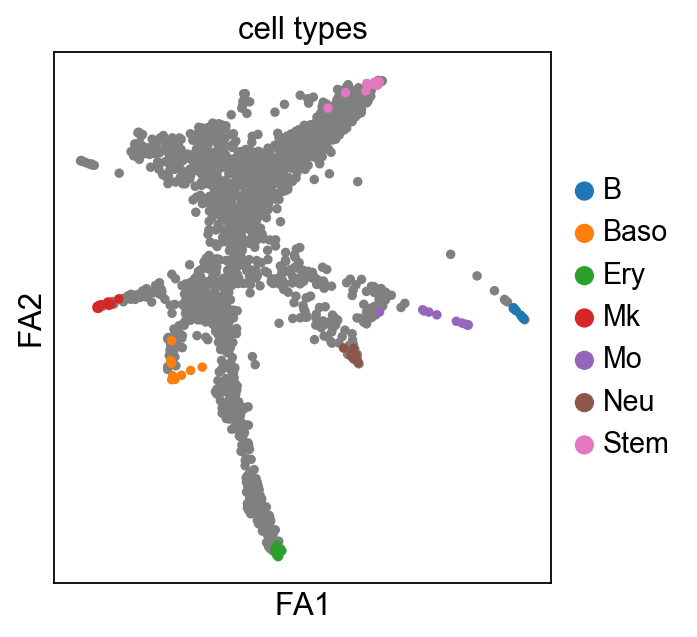

In [6]:
sc.pl.draw_graph(adata, color='cell_types')

Recompute the graph using diffusion maps. Truncating at a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components; this is very similar to denoising a data matrix using PCA.

In [7]:
adata_denoised = adata.copy()
sc.tl.diffmap(adata_denoised)
sc.pp.neighbors(adata_denoised, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [ 1.            0.9948366284  0.9920881391  0.9910871387  0.9855608344
      0.9833057523  0.9819453359  0.9770339727  0.9750932455  0.972073555
      0.9695823193  0.9595955014  0.9555426836  0.9498624802  0.9467586875]
    finished (0:00:00.07) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing neighbors
    finished (0:00:00.28) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [8]:
adata_denoised.write(results_file_denoised)

## Clustering 

In [9]:
adata = sc.read(results_file_denoised)

Cluster the denoised graph.

In [10]:
sc.tl.louvain(adata, resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.08) --> found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Embed the denoised graph.

In [11]:
sc.tl.draw_graph(adata, layout='fa', random_state=1)

drawing single-cell graph using layout "fa"
    finished (0:00:07.60) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|
|Lymphoid| Dntt, Il7r|

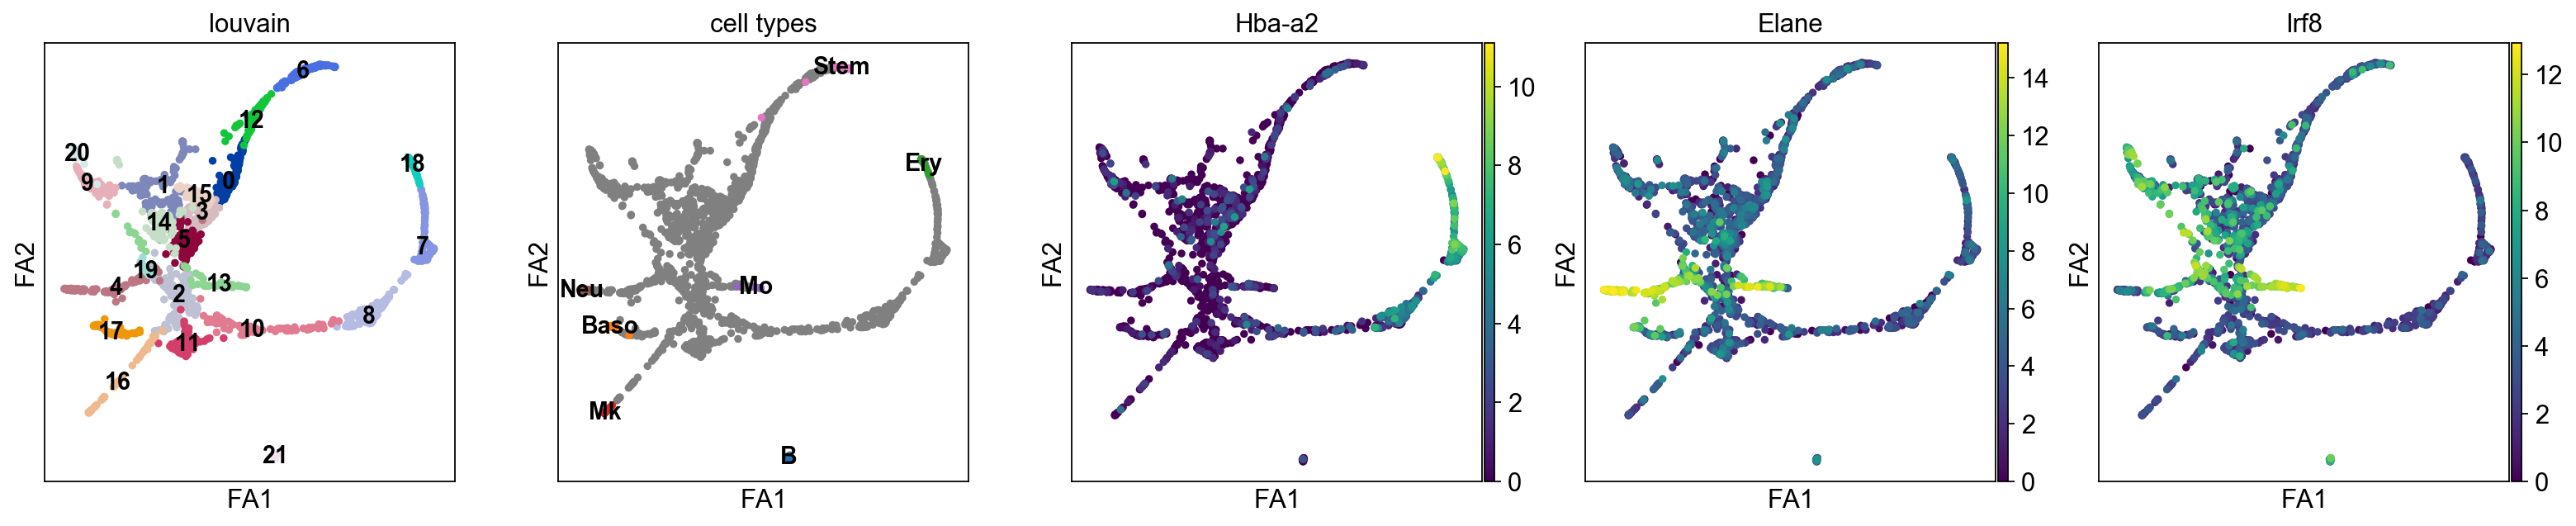

In [12]:
sc.pl.draw_graph(adata, color=['louvain', 'cell_types', 'Hba-a2', 'Elane', 'Irf8'], legend_loc='on data')

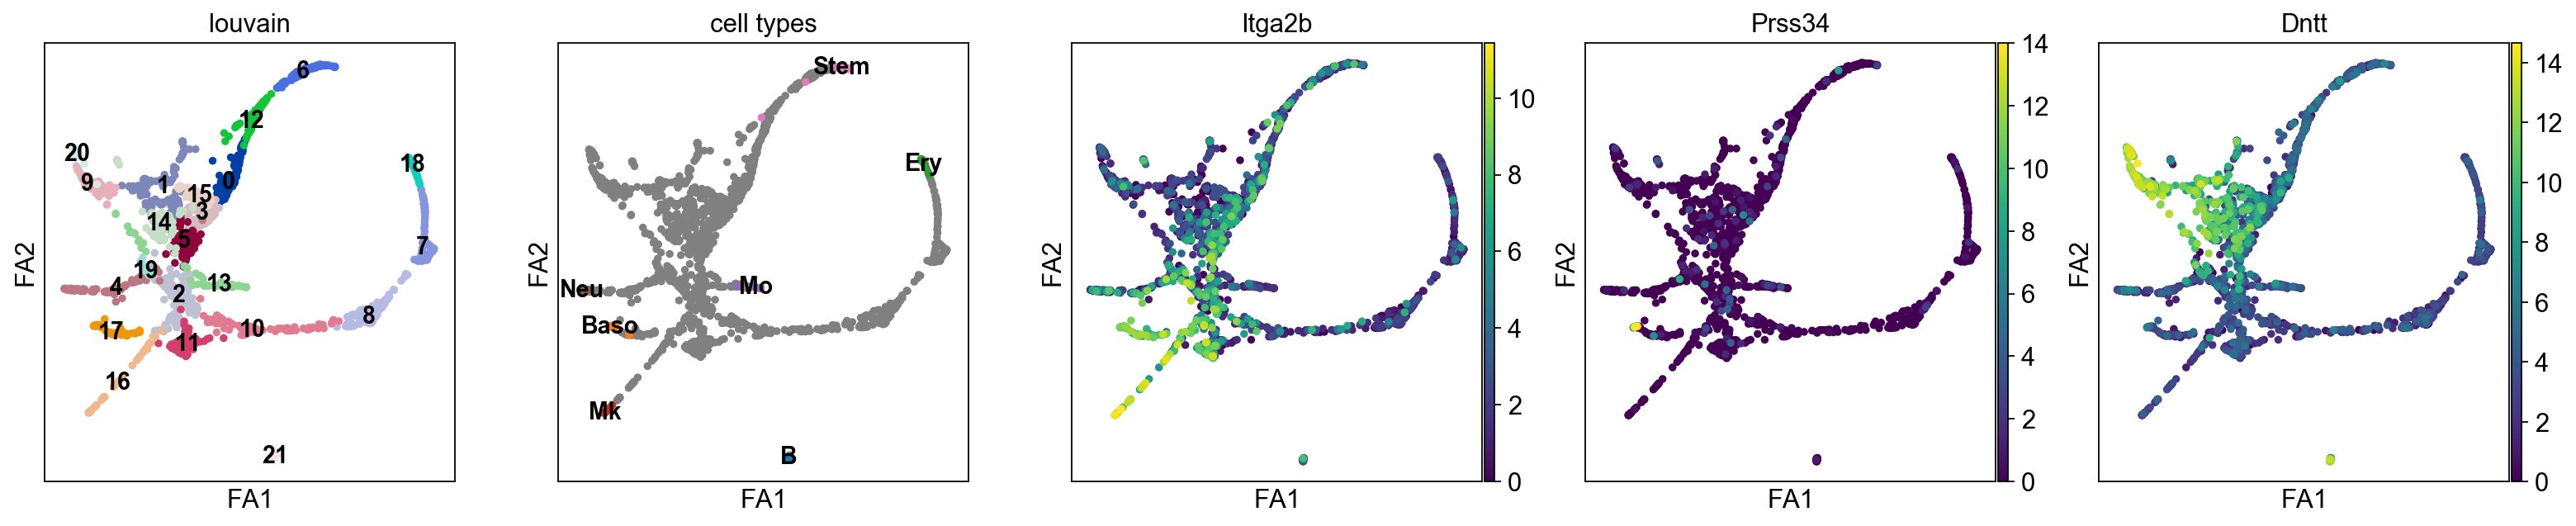

In [13]:
sc.pl.draw_graph(adata, color=['louvain', 'cell_types', 'Itga2b', 'Prss34', 'Dntt'], legend_loc='on data')

In [14]:
adata.obs['clusters'] = adata.obs['louvain']

In [15]:
adata.obs['clusters'].cat.categories = [
    '0', '1', '2', '3', '4/Neu', '5', '6/Stem', '7', '8', '9', '10', '11', '12',
    '13/Mo', '14', '15', '16/Mk', '17/Baso', '18/Ery', '19', '20/Lymph', '21']

Let us generate another annotation by directly computing overlaps with experimental labels.

In [16]:
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='louvain', reference='cell_types', normalization='prediction')
# the largest group is the no_gate group, appearing as '', drop the newline from the name
asso_names_stripped = [name.replace('\n', '') if '\n' in name else str(i) for i, name in enumerate(asso_names)]
asso_names = [str(i) + '/' + name.replace('\n', '') if '\n' in name else str(i) for i, name in enumerate(asso_names)]

Ignoring category 'no_gate' as it's in `settings.categories_to_ignore`.


In [17]:
color_dict = dict(zip(adata.obs['cell_types'].cat.categories, adata.uns['cell_types_colors']))
asso_colors = [color_dict[n] if n in color_dict else 'grey' for n in asso_names_stripped]

In [18]:
adata.obs['clusters_ref'] = pd.Categorical(adata.obs['louvain'].cat.codes)
adata.obs['clusters_ref'].cat.categories = pd.Index(asso_names)
adata.uns['clusters_ref_colors'] = asso_colors

exporting label positions to ./write/pos.csv
exporting label positions to ./write/pos.csv


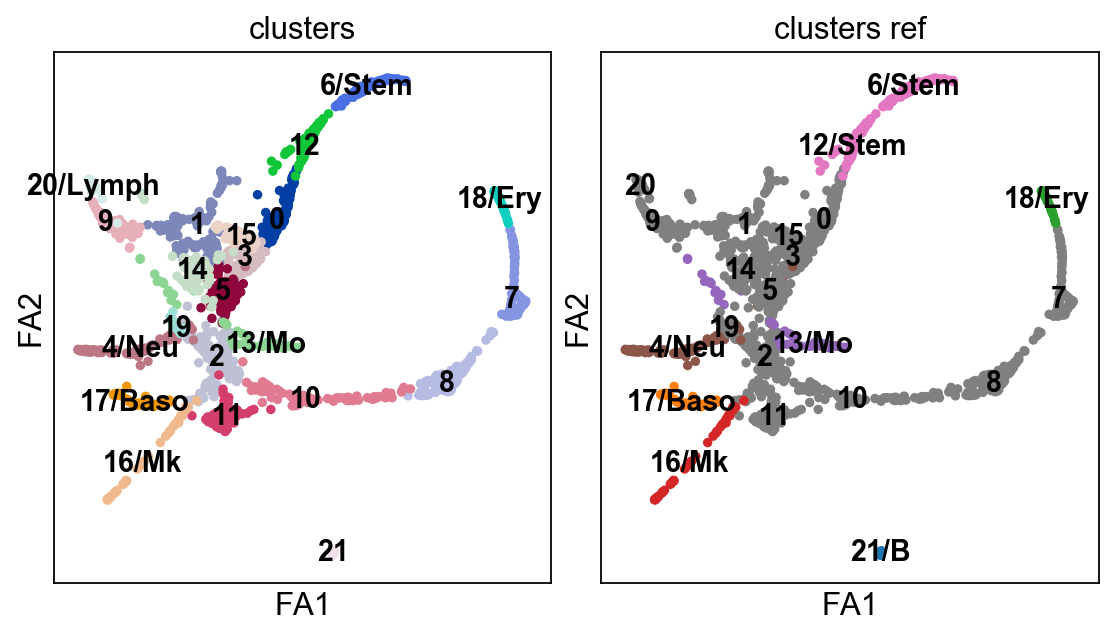

In [19]:
sc.pl.draw_graph(adata, color=['clusters', 'clusters_ref'], legend_loc='on data export')

### PAGA

In [20]:
sc.tl.paga(adata, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.12) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


Usually, we don't use the positions from the single-cell graph... only here, this is already very clear.

In [21]:
pos = np.loadtxt('./write/pos.csv', delimiter=',')

In [22]:
pos[13] = [-3000, 700]
pos[17] = [-500, -8000]
pos[19] = [-3000, -600]

--> added 'pos', the PAGA positions (adata.uns['paga'])


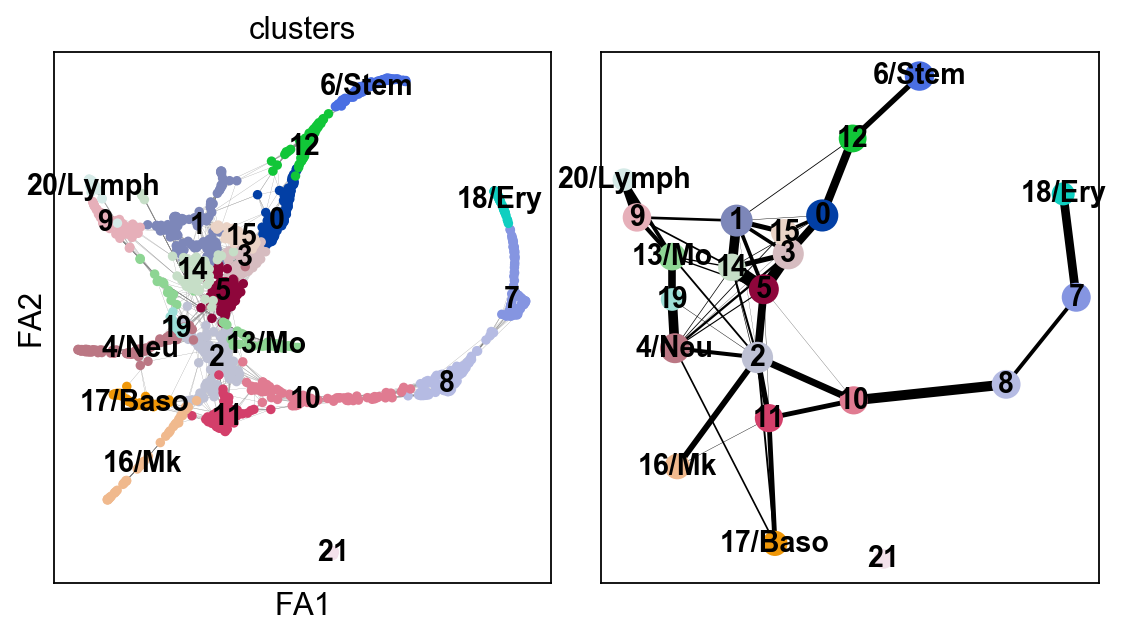

In [24]:
sc.pl.paga_compare(adata, basis='X_draw_graph_fa', pos=pos)

Let's use the PAGA result to improve on the single-cell layout.

In [25]:
sc.tl.draw_graph(adata, init_pos='paga', maxiter=50)

drawing single-cell graph using layout "fa"
    finished (0:00:00.93) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


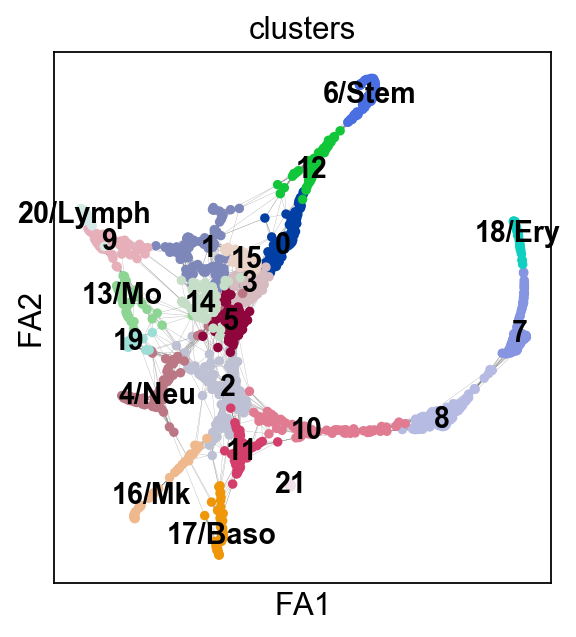

In [26]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data', edges=True)

Choose the colors a bit more consistently.

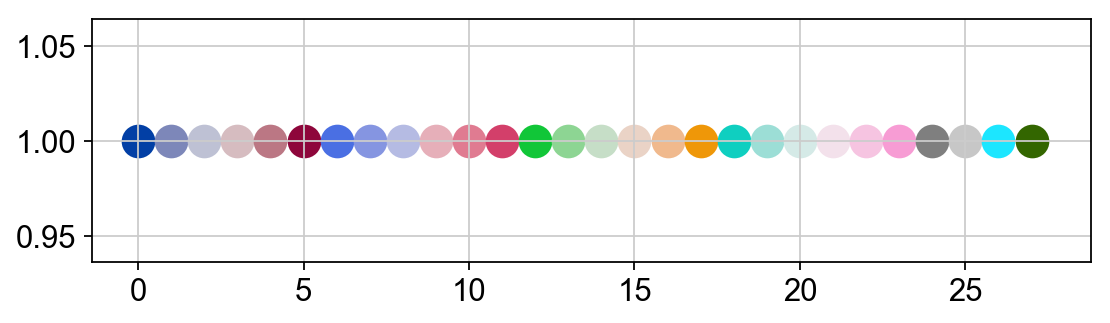

In [27]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [28]:
orig_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = orig_colors.copy()

In [29]:
new_colors[[6, 12, 0, 15, 3]] = orig_colors[[12, 13, 14, 14, 14]]  # Stem colors / green
new_colors[[18, 7, 8, 10]] = orig_colors[[5, 11, 10, 9]]  # Ery colors / red
new_colors[[16]] = orig_colors[[17]]  # Mk early Ery colors / yellow
new_colors[[11, 20, 5, 2]] = orig_colors[[2, 8, 20, 25]]  # lymph progenitors / grey
new_colors[[17]] = orig_colors[[18]]  # Baso / turquoise
new_colors[[4, 19]] = orig_colors[[6, 7]]  # Neu / light blue
new_colors[[13, 9]] = orig_colors[[0, 1]]  # Mo / dark blue

In [30]:
adata.uns['clusters_colors'] = new_colors

Add some white space to the categorie for plotting.

In [31]:
adata.rename_categories(
    'clusters',
    ['0', '1', '2', '3', '4/Neu                ', '5', '6/Stem                 ', '7', '8', '9', '10', '11',
     '12', '13/Mo                ', '14', '15', '16/Mk              ', '17/Baso               \n\n', '18/Ery\n\n', '19', '20/Lymph\n\n', '21'])

In [44]:
axs = sc.pl.paga_compare(
    adata, title='', right_margin=0.2, size=20, pos=pos, threshold=0.12,
    legend_fontsize=12, fontsize=12, frameon=False, show=False)

--> added 'pos', the PAGA positions (adata.uns['paga'])


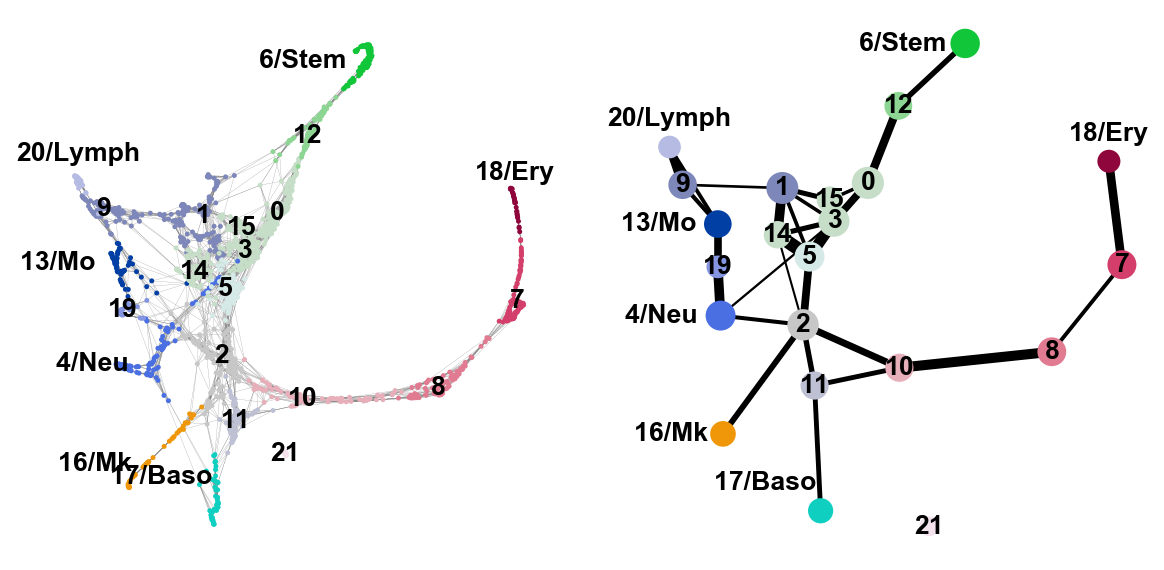

In [45]:
pl.sca(axs[0])
pl.xlabel('')
pl.ylabel('')
axs[0].set_frame_on(False)
pl.savefig('./figures/paga_compare_nestorowa16.pdf')
pl.show()

In [46]:
adata.write(results_file_denoised)

### Reconstruct gene changes along paths for some marker genes.

In [47]:
adata = sc.read(results_file_denoised)
root_cell = int(np.where(adata.obs['cell_types'] == 'Stem')[0][0])
adata.uns['iroot'] = root_cell

In [48]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


In [49]:
adata.write(results_file_denoised)

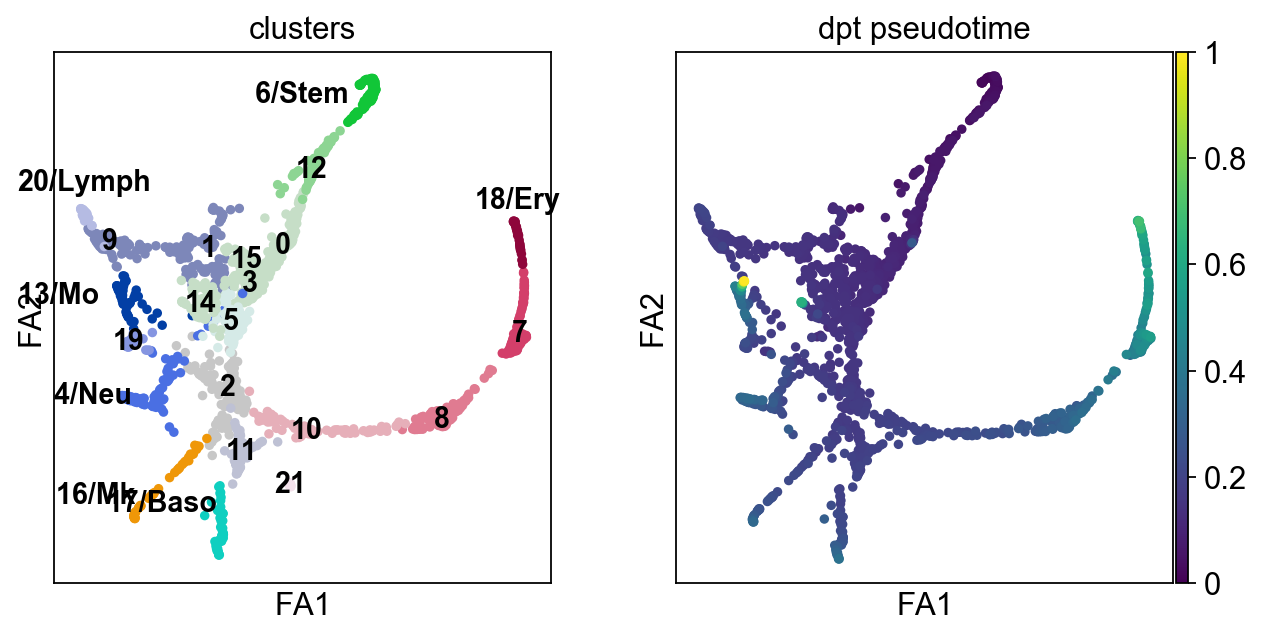

In [50]:
sc.pl.draw_graph(adata, color=['clusters', 'dpt_pseudotime'], legend_loc='on data')

Look at marker genes along some trajectories - genes for different stages.

In [51]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

The first 5 genes mark different stages of the erythroid trajectory - going from early to late. The remaining genes neutrophil (Elane, Cebpe) and monocyte (Irf8, Csf1r, Ctsg).

In [56]:
paths = [('erythrocytes', [6, 12, 0, 3, 5, 2, 10, 8, 7, 18]),
         ('neutrophils', [6, 12, 0, 3, 4]),
         ('monocytes', [6, 12, 0, 3, 1, 9, 13])]

In [52]:
paths = [('erythrocytes', ['6/Stem', '12', '0', '3', '5', '2', '10', '8', '7', '18/Ery']),
         ('neutrophils', ['6/Stem', '12', '0', '3', '4/Neu']),
         ('monocytes', ['6/Stem', '12', '0', '3', '1', '9', '13/Mo'])]

In [57]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [58]:
adata.raw = sc.AnnData(sc.pp.scale(adata.raw.X, copy=True),
                       var=adata_denoised.raw.var)

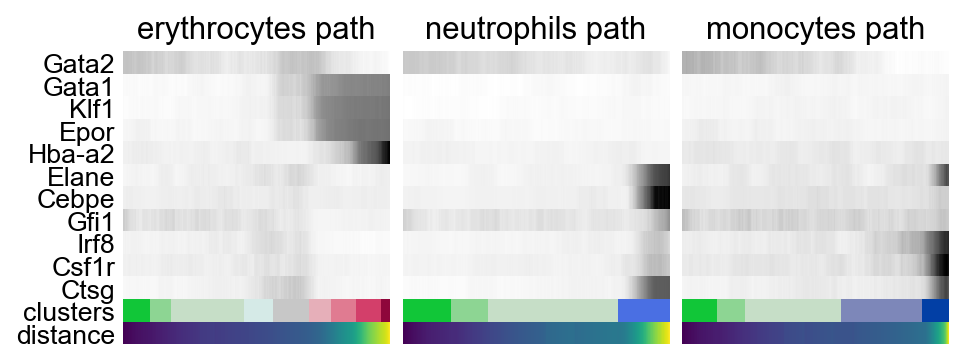

In [60]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_nestorowa16.pdf')
pl.show()